# Parte B — GAN básica para MNIST (generación de dígitos)


**1.- Imports, carga MNIST y escalado**



In [ ]:
print("[B1] Importando y preparando datos MNIST para GAN...")

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist

# reproducibilidad adicional
np.random.seed(0); tf.random.set_seed(0)

# datos
(x_train, _), (_, _) = mnist.load_data()
x_train = (x_train.astype("float32") - 127.5) / 127.5  # [-1, 1]
x_train = np.expand_dims(x_train, axis=-1)            # (N,28,28,1)

BUFFER_SIZE = 60000
BATCH_SIZE  = 128
LATENT_DIM  = 100
EPOCHS_GAN  = 10

dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(f"[B1] MNIST → x_train: {x_train.shape}, rango≈[{x_train.min():.1f},{x_train.max():.1f}]")


[B1] Importando y preparando datos MNIST para GAN...
11490434/11490434 [==============================] - 1s 0us/step
[B1] MNIST → x_train: (60000, 28, 28, 1), rango≈[-1.0,1.0]


**2.- Definir Generador y Discriminador**



In [ ]:
print("[B2] Construyendo Generador y Discriminador...")

def build_generator(latent_dim=LATENT_DIM):
    model = models.Sequential(name="Generator")
    model.add(layers.Input(shape=(latent_dim,)))
    model.add(layers.Dense(7*7*128))
    model.add(layers.Reshape((7,7,128)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1, kernel_size=4, strides=2, padding='same', activation='tanh'))  # salida [-1,1]
    return model

def build_discriminator():
    model = models.Sequential(name="Discriminator")
    model.add(layers.Input(shape=(28,28,1)))
    model.add(layers.Conv2D(64, kernel_size=4, strides=2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))  # prob real/falso
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

G = build_generator()
D = build_discriminator()
G.summary()
D.summary()
print("[B2] Modelos listos.")


[B2] Construyendo Generador y Discriminador...

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 128)         512       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        131136    
 anspose)                                                        
                                                                 
 batch_no

**3.- Bucle de entrenamiento adversarial**


[B3] Configurando entrenamiento adversarial...
[B3] Iniciando entrenamiento...
[B3][Epoch 01/10] D_loss=0.2332 | G_loss=1.6950
[B3][Epoch 02/10] D_loss=0.3341 | G_loss=1.7175
[B3] Muestras del generador:


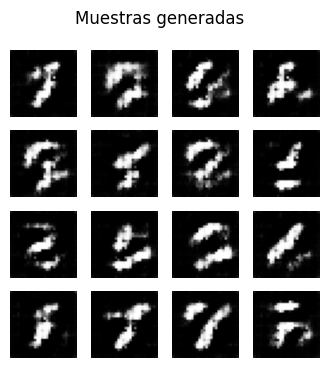

[B3][Epoch 03/10] D_loss=0.4827 | G_loss=1.5258
[B3][Epoch 04/10] D_loss=0.5580 | G_loss=1.2118
[B3] Muestras del generador:


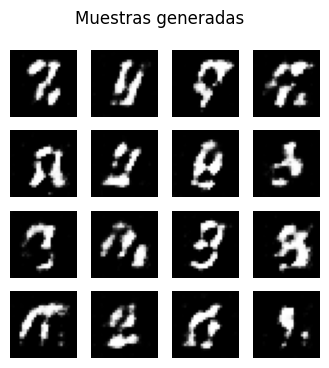

[B3][Epoch 05/10] D_loss=0.5782 | G_loss=1.0517
[B3][Epoch 06/10] D_loss=0.5696 | G_loss=1.0776
[B3] Muestras del generador:


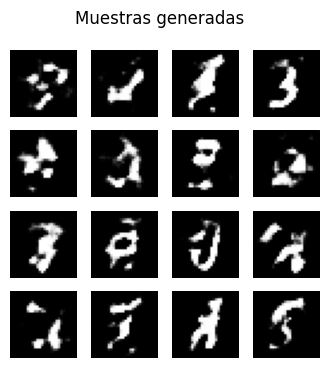

[B3][Epoch 07/10] D_loss=0.5885 | G_loss=1.0216
[B3][Epoch 08/10] D_loss=0.5681 | G_loss=1.0948
[B3] Muestras del generador:


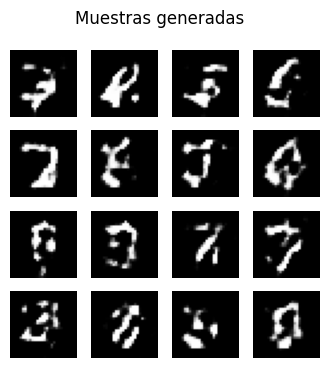

[B3][Epoch 09/10] D_loss=0.5503 | G_loss=1.1522
[B3][Epoch 10/10] D_loss=0.5367 | G_loss=1.1083
[B3] Muestras del generador:


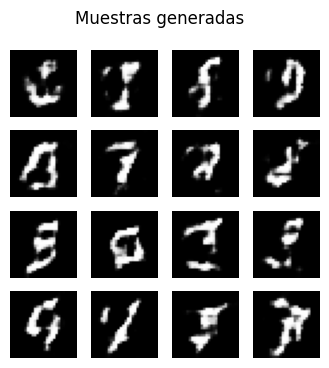

[B3] Entrenamiento completado en 1051.8s.
[B3] Fin de Parte B.


In [ ]:
print("[B3] Configurando entrenamiento adversarial...")

# GAN combinada: congelamos D cuando entrenamos G
D.trainable = False
z = layers.Input(shape=(LATENT_DIM,))
fake_img = G(z)
valid = D(fake_img)
GAN = models.Model(z, valid, name="GAN")
GAN.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy')

print("[B3] Iniciando entrenamiento...")
import time
start = time.time()

def sample_and_show(generator, n=16):
    import matplotlib.pyplot as plt
    noise = np.random.normal(size=(n, LATENT_DIM))
    gen = generator.predict(noise, verbose=0)
    gen = (gen * 127.5 + 127.5).astype("uint8")  # volver a [0,255]
    plt.figure(figsize=(4,4))
    for i in range(n):
        plt.subplot(4,4,i+1)
        plt.imshow(gen[i,...,0], cmap='gray')
        plt.axis('off')
    plt.suptitle("Muestras generadas")
    plt.show()

for epoch in range(1, EPOCHS_GAN+1):
    d_loss_epoch = []; g_loss_epoch = []
    for real_batch in dataset:
        # 1) Entrenar Discriminador
        b = real_batch.shape[0]
        noise = np.random.normal(size=(b, LATENT_DIM))
        fake_batch = G.predict(noise, verbose=0)

        x = np.concatenate([real_batch, fake_batch], axis=0)
        y = np.concatenate([np.ones((b,1)), np.zeros((b,1))], axis=0)

        D.trainable = True
        d_loss, d_acc = D.train_on_batch(x, y)
        d_loss_epoch.append(d_loss)

        # 2) Entrenar Generador (vía GAN combinada): etiquetas "reales"
        noise = np.random.normal(size=(b, LATENT_DIM))
        y_gen = np.ones((b,1))
        D.trainable = False
        g_loss = GAN.train_on_batch(noise, y_gen)
        g_loss_epoch.append(g_loss)

    print(f"[B3][Epoch {epoch:02d}/{EPOCHS_GAN}] D_loss={np.mean(d_loss_epoch):.4f} | G_loss={np.mean(g_loss_epoch):.4f}")

    if epoch % 2 == 0:
        print("[B3] Muestras del generador:")
        sample_and_show(G, n=16)

print(f"[B3] Entrenamiento completado en {time.time()-start:.1f}s.")
print("[B3] Fin de Parte B.")
